In [3]:
import pandas as pd, numpy as np, seaborn as sns, geopandas as gpd, matplotlib.pyplot as plt
from scipy.stats import f_oneway
import pingouin as pin
import matplotlib

from shapely.geometry import Point, mapping
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

pd.set_option("display.precision", 2)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

import cityImage as ci, ABManalysis as af

#libraries for clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score

### Preparing and cleaning the routes

### Coordinate System of the case study area for cartographic visualisations

In [4]:
city_name = 'Muenster'
epsg = 25832
crs = 'EPSG:'+str(epsg)

# Questionnaire
## 1. Pre-processing

In [5]:
raw = pd.read_csv("Input/empiricalABM/Muenster_responses_matrix.csv") # raw responses
raw['startdate'] = raw.apply(lambda row: row['startdate'][11:], axis = 1)
raw['datestamp'] = raw.apply(lambda row: row['datestamp'][11:], axis = 1)
raw['duration'] = raw.apply(lambda row: af.compute_duration(row['startdate'], row['datestamp']), axis = 1)    
raw['PD2'] = raw['PD2'].fillna(raw['PD2'].mean())
raw['age'] = raw['PD2'].astype(int)
print('Number of total participants:', str(len(raw)))

Number of total participants: 418


### 1.1 Disregard subjects who took less than 20 minutes to complete the study

In [6]:
# cleaning
raw = raw[raw['duration']>= 20].copy()
print('Number of participants whose record was not disregarded ', str(len(raw)))
limit = {'A1':18, 'A2':25, 'A3':33, 'A4':41, 'A5':49, 'A6':57, 'A7':65, 'A8':73, 'A9':150}
raw['limit'] = raw[~raw.FQ1.isnull()].apply(lambda row: limit[row['FQ1']], axis = 1)
# print("age issue", len(raw[~raw.FQ1.isnull()][['PD2', 'FQ1', 'limit']][raw.age > raw.limit]) + 
#       len(raw[~raw.FQ1.isnull()][['PD2', 'FQ1', 'limit']][raw.age < raw.limit-7]))

Number of participants whose record was not disregarded  301


In [7]:
raw.rename(columns={"PD1": "sex"}, inplace = True)
values = ['A1', 'A2', 'A3', 'A4']
new_values = ["male", "female", "non-binary", "prefer not to"]
for n, value in enumerate(values):
    raw['sex'].replace(value, new_values[n], inplace = True)

### 1.1 Disregarding subjects who always chose the same response when asked how to proceed along the route

In [8]:
def check(index):
    response = list(raw[to_check].loc[index][raw[to_check].loc[index].notna()])
    percentageA1 = response.count("A1")/len(response)
    percentageA2 = response.count("A2")/len(response)
    if ((percentageA1 > 0.65) | (percentageA2 > 0.65)) & (raw.loc[index].duration < 30):
        return True
    return False

# checking videos
video_columns = [col for col in raw if col.startswith('VD')]
to_remove = ['VD000a','VD000','VD099[SQ001]', 'VD100a', 'VD100', 'VD199[SQ001]','VD200a','VD200', 'VD299[SQ001]']
to_check = [item for item in video_columns if item not in to_remove]
raw['allSame'] = raw.apply(lambda row: check(row.name), axis = 1)

## 2. Demographic information

### 2.1 General information

In [9]:
nr = 'Number'
pr = 'participants'

N = len(raw)
print(nr+' of female '+pr +': '+str(len(raw[raw.sex == 'female']))+', '+str(round(len(raw[raw.sex == 'female'])/N*100,1))+'%')
print(nr+' of male '+pr +': '+str( len(raw[raw.sex == 'male']))+', '+str(round(len(raw[raw.sex == 'male'])/N*100,1))+'%')
print(nr+' of non-binary '+pr +': '+str(len(raw[raw.sex == 'non-binary']))+', '+str(round(len(raw[raw.sex == 'non-binary'])/N*100, 1))+'%')
print(nr+' of '+pr+' who preferred not to declare their gender: '+str(len(raw[raw.sex == 'prefer not to']))+', '+
      str(round(len(raw[raw.sex == 'prefer not to'])/N*100, 1))+'%')
print()
print("Particpants' mean age:", round(raw['age'].mean(),3))
print("Particpants' std age:", round(raw['age'].std(), 3))
print()
print('Mean duration:', str(round(raw.duration.mean(), 2))+" minutes")

Number of female participants: 188, 62.5%
Number of male participants: 110, 36.5%
Number of non-binary participants: 2, 0.7%
Number of participants who preferred not to declare their gender: 1, 0.3%

Particpants' mean age: 27.857
Particpants' std age: 9.352

Mean duration: 53.69 minutes


### 2.2 Age categories

In [10]:
Ga = len(raw[raw.age < 18])
Gb = len(raw[(raw.age >= 18) & (raw.age <= 25)])
Gc = len(raw[(raw.age >= 26) & (raw.age <= 33)])
Gd = len(raw[(raw.age >= 34) & (raw.age <= 41)])
Ge = len(raw[(raw.age >= 42) & (raw.age <= 49)])
Gf = len(raw[(raw.age >= 50) & (raw.age <= 57)])
Gg = len(raw[(raw.age >= 58) & (raw.age <= 65)])
Gh = len(raw[(raw.age >= 66) & (raw.age <= 73)])
Gi = len(raw[(raw.age >= 74)])

print("Number of participants per age group")
print()
print('< 18: '+str(Ga)+', '+str(round(Ga/N*100, 1))+ '%')
print('18 - 25: '+str(Gb)+', '+str(round(Gb/N*100, 1))+ '%')
print('26 - 33: '+str(Gc)+', '+str(round(Gc/N*100, 1))+ '%')
print('34 - 41: '+str(Gd)+', '+str(round(Gd/N*100, 1))+ '%')
print('42 - 49: '+str(Ge)+', '+str(round(Ge/N*100, 1))+ '%')
print('50 - 57: '+str(Gf)+', '+str(round(Gf/N*100, 1))+ '%')
print('58 - 65: '+str(Gg)+', '+str(round(Gg/N*100, 1))+ '%')
print('66 - 73: '+str(Gh)+', '+str(round(Gh/N*100, 1))+ '%')
print('> 74:'+str(Gi)+', '+str(round(Gi/N*100, 1))+ '%')

Number of participants per age group

< 18: 0, 0.0%
18 - 25: 147, 48.8%
26 - 33: 114, 37.9%
34 - 41: 15, 5.0%
42 - 49: 7, 2.3%
50 - 57: 8, 2.7%
58 - 65: 8, 2.7%
66 - 73: 2, 0.7%
> 74:0, 0.0%


### 2.3 Links or relationship to the case-study area

In [11]:
Ga = len(raw[~raw['PD3[SQ001]'].isnull()])
Gb = len(raw[~raw['PD3[SQ002]'].isnull()])
Gc = len(raw[~raw['PD3[SQ003]'].isnull()])
Gd = len(raw[~raw['PD3[SQ004]'].isnull()])
Ge = len(raw[~raw['PD3[SQ005]'].isnull()])

nr = "Number of participants who "

print(nr+'are tourists: '+str(Ga)+', '+str(round(Ga/N*100,1))+ '%')
print(nr+'work here: '+str(Gb)+', '+str(round(Gb/N*100,1))+ '%')
print(nr+'live her: '+str(Gc)+', '+str(round(Gc/N*100,1))+ '%')
print(nr+'study here: '+str(Gd)+', '+str(round(Gd/N*100,1))+ '%')
print(nr+'are occasional visitors: '+str(Ge)+', '+str(round(Ge/N*100,1))+ '%')

Number of participants who are tourists: 1, 0.3%
Number of participants who work here: 93, 30.9%
Number of participants who live her: 200, 66.4%
Number of participants who study here: 255, 84.7%
Number of participants who are occasional visitors: 16, 5.3%


### 2.4 Reasons for walking

In [12]:
columns = ['WB2[SQ001]', 'WB2[SQ002]','WB2[SQ003]','WB2[SQ004]','WB2[SQ005]']
labels = ['Commuting to/from work', 'Commuting to/from school/college/university', 'For social activities', 
          'For exercise or free-time activities', 'For other daily errands and commitments']
          
for column in columns: 
    raw[column].replace('A1', 1, inplace = True)
    raw[column].replace('A2', 2, inplace = True)
    raw[column].replace('A3', 3, inplace = True)
    raw[column].replace('A4', 4, inplace = True)
    raw[column].replace('A5', 5, inplace = True)

total_prob = 0.0
for n, column in enumerate(columns):
    prob = round(raw[column].mean(),3)
    total_prob += prob
    print(labels[n]+':', str(round(raw[column].mean(),3))) # value on the Likert scale
    print("percentage: ", str(round(raw[column].mean()*100/5,3))+'%')
    if n < len(columns)-1: 
        print()

Commuting to/from work: 1.88
percentage:  37.608%

Commuting to/from school/college/university: 2.465
percentage:  49.302%

For social activities: 3.15
percentage:  62.99%

For exercise or free-time activities: 3.535
percentage:  70.698%

For other daily errands and commitments: 3.455
percentage:  69.103%


#### *Reasons for Walking: Transformation into probabilities*

In [13]:
for n, column in enumerate(columns):
    actual_prob = round(raw[column].mean()/total_prob,2)
    print(str(labels[n]) + ': '+str(actual_prob))

Commuting to/from work: 0.13
Commuting to/from school/college/university: 0.17
For social activities: 0.22
For exercise or free-time activities: 0.24
For other daily errands and commitments: 0.24


## 3. Familiriaty, spatial knowledge and preferences
### 3.1 Time spent living in the case-study area (*familiarity*)

<AxesSubplot:ylabel='Density'>

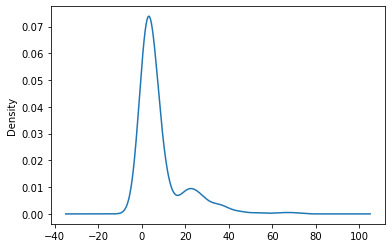

In [14]:
raw[['PD4[SQ001]', 'PD4[SQ002]']] = raw[['PD4[SQ001]', 'PD4[SQ002]']].fillna(0.0)
raw['PD4[SQ002]'].replace(1984.0, 2021-1984, inplace = True)
raw['familiarity'] = raw['PD4[SQ001]']/12 + raw['PD4[SQ002]']
raw['familiarity'].plot.kde()

### 3.2 Self-reported spatial knowledge

<AxesSubplot:ylabel='Density'>

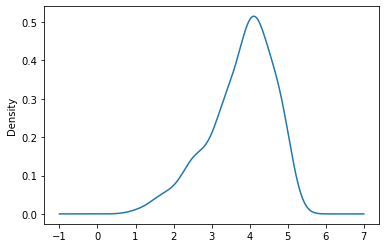

In [15]:
columns = ['WB4[SQ001]', 'WB4[SQ002]','WB4[SQ003]','WB4[SQ004]']
for column in columns: 
    raw[column].replace('A1', 1, inplace = True)
    raw[column].replace('A2', 2, inplace = True)
    raw[column].replace('A3', 3, inplace = True)
    raw[column].replace('A4', 4, inplace = True)
    raw[column].replace('A5', 5, inplace = True)
raw['knowledge'] = (raw['WB4[SQ001]'] + raw['WB4[SQ002]'] + raw['WB4[SQ003]'] +raw['WB4[SQ004]'])/4
raw['knowledge'].plot.kde()

In [16]:
columns = ['WB4[SQ001]', 'WB4[SQ002]','WB4[SQ003]','WB4[SQ004]', 'knowledge', 'familiarity']
raw[columns].corr(method='pearson')

,WB4[SQ001],WB4[SQ002],WB4[SQ003],WB4[SQ004],knowledge,familiarity
WB4[SQ001],1.000,0.756,0.459,0.423,0.832,0.192
WB4[SQ002],0.756,1.000,0.482,0.475,0.864,0.165
WB4[SQ003],0.459,0.482,1.000,0.531,0.743,0.174
WB4[SQ004],0.423,0.475,0.531,1.000,0.760,0.168
knowledge,0.832,0.864,0.743,0.760,1.000,0.217
familiarity,0.192,0.165,0.174,0.168,0.217,1.000


### 3.3 Preference for and aversion to barriers

In [17]:
columns = ['SP4[SQ002]', 'SP4[SQ006]','SP4[SQ001]','SP4[SQ005]']
for column in columns: 
    raw[column].replace('A1', 0.00, inplace = True)
    raw[column].replace('A2', 0.25, inplace = True)
    raw[column].replace('A3', 0.50, inplace = True)
    raw[column].replace('A4', 0.75, inplace = True)
    raw[column].replace('A5', 1.00, inplace = True)

raw['preferenceNatural'] = (raw['SP4[SQ002]'] + raw['SP4[SQ006]'])/2 ## preference for Natural Barriers
raw['aversionSevering'] = raw['SP4[SQ001]'] ## Aversion to Severing Barriers

## 4. Video Tasks: route choice behaviour variables
#### *Preliminary columns cleaning*

In [18]:
video_columns = [col for col in raw if col.startswith('VD')]
to_remove = ['VD000a','VD000','VD099[SQ001]', 'VD100a', 'VD100', 'VD199[SQ001]','VD200a','VD200', 'VD299[SQ001]']

columns = ['id'] + video_columns
columns = [item for item in columns if item not in to_remove] # remove not necessary video columns
responses = raw[columns].copy() # only response to the video taks

In [19]:
# cleaning and rename columns and prepare a legible dataframe 
for column in responses.columns:
    if column == 'id':
        continue
    responses.rename({column: column[2:]}, axis=1, inplace = True)
    
for column in responses.columns:
    if column == 'id':
        continue
    if ('a' in column) | ('b' in column): 
        continue
    new_column = '-'.join(column[i:i+3] for i in range(0, len(column), 3))
    responses.rename({column: new_column}, axis=1, inplace = True)
    
responses.rename({'150a151152': '150a-151-152'}, axis=1, inplace = True)
responses.rename({'150b126': '150b-126'}, axis=1, inplace = True)

#### *Loading the routes used in the survey* 

In [20]:
survey_routes = gpd.read_file("Outputs/Routes_sections.shp").to_crs(crs)
summary = pd.DataFrame(columns = ['id']+list(survey_routes.video.unique()))
del summary[None]

summary = summary.reindex(sorted(summary.columns), axis=1)

for row in responses.itertuples():
    sectors = responses.loc[row.Index].notna().dot(responses.columns+',').rstrip(',')
    sectors = sectors.replace('-', ',')
    sectors_list = sectors.strip('').split(',')
    for sector in sectors_list:
        summary.at[row.Index, sector] = 1
        summary.at[row.Index, 'id'] = responses.loc[row.Index].id
        
summary.drop('114', inplace = True, axis = 1)
summary.fillna(0, inplace = True)
for column in summary.columns: 
    summary.rename(columns={column: str(column)}, inplace = True)

In [21]:
summary.head()

,001,002,003,004,005,006,007,008,009,010,...,219,220,221,222,223,224,225,226,227,id
0,0,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,9
1,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
2,1,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,13
3,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14
4,1,1,1,0,0,0,0,0,1,0,...,0,1,1,1,1,0,0,0,0,15


### 4.1 Obtaining the general statistics

In [22]:
survey_routes['routeChoice'] = survey_routes.apply(lambda row: row['routeChoic'].replace(" ",""), axis = 1)
survey_routes['routeChoice'] = survey_routes.apply(lambda row: row['routeChoice'].strip('][').split(','), axis = 1)
survey_routes.drop('routeChoic', inplace = True, axis = 1)

#### *Computing for each subject how much they resorted to certain urban elements or road costs*

In [23]:
route_variables = ['usingElements', 'noElements','onlyDistance', 'onlyAngular', 'distanceHeuristic', 'angularHeuristic', 
                   'regions', 'routeMarks', 'barriers','distantLandmarks', 'preferenceNatural', 'aversionSevering']
other_variables = ["length", "minimisation_length","combined_length"]

video0 = [col for col in summary if col.startswith('0')]
video1 = [col for col in summary if col.startswith('1')]
video2 = [col for col in summary if col.startswith('2')]
videos = [video0, video1, video2]
routes_stats = af.set_routes_stats(summary, survey_routes, videos)

In [24]:
raw.index = raw['id']
routes_stats.index.name = None
routes_stats['preferenceNatural'] = raw['preferenceNatural']
routes_stats['aversionSevering'] = raw['aversionSevering']
routes_stats['knowledge'] = raw['knowledge']
routes_stats.head(10)

,onlyDistance,onlyAngular,distanceHeuristic,angularHeuristic,regions,routeMarks,barriers,distantLandmarks,usingElements,noElements,length,combined_length,minimisation_length,preferenceNatural,aversionSevering,knowledge
9,0.562,0.438,0.638,0.362,0.273,0.165,0.529,0.621,0.695,0.305,4347.289,3582.347,1432.933,0.500,0.750,4.500
10,0.640,0.360,0.548,0.452,0.323,0.328,0.456,0.590,0.612,0.388,4224.494,3580.186,2216.425,0.750,0.750,4.000
13,0.555,0.445,0.612,0.388,0.371,0.210,0.574,0.711,0.695,0.305,4291.776,4291.756,2142.342,0.125,0.250,4.750
14,0.696,0.304,0.474,0.526,0.461,0.321,0.320,0.687,0.622,0.378,5005.314,4171.568,2344.756,0.750,1.000,3.500
15,0.492,0.508,0.629,0.371,0.373,0.431,0.378,0.490,0.635,0.365,4339.647,2988.757,1597.901,0.750,0.750,4.250
17,0.659,0.341,0.625,0.375,0.280,0.254,0.462,0.757,0.637,0.363,4316.350,3919.428,2243.072,0.375,0.500,3.250
19,0.624,0.376,0.562,0.438,0.516,0.155,0.475,0.513,0.745,0.255,4479.973,4479.953,1770.501,0.375,0.750,4.750
20,0.596,0.404,0.518,0.482,0.610,0.740,0.102,0.131,0.590,0.410,4670.991,3742.692,2700.807,0.375,0.250,4.000
22,0.696,0.304,0.485,0.515,0.458,0.352,0.295,0.719,0.639,0.361,4864.052,4146.069,2344.756,0.500,0.500,4.500
24,0.412,0.588,0.634,0.366,0.368,0.611,0.389,0.220,0.681,0.319,4454.943,4058.041,2239.914,0.500,0.500,4.750


In [25]:
## appending variables regarding the preference for natural/severing barriers and spatial knowledge
raw.index = raw['id']
routes_stats.index.name = None
routes_stats['preferenceNatural'] = raw['preferenceNatural']
routes_stats['aversionSevering'] = raw['aversionSevering']
routes_stats['knowledge'] = raw['knowledge']
routes_stats.head(10)

,onlyDistance,onlyAngular,distanceHeuristic,angularHeuristic,regions,routeMarks,barriers,distantLandmarks,usingElements,noElements,length,combined_length,minimisation_length,preferenceNatural,aversionSevering,knowledge
9,0.562,0.438,0.638,0.362,0.273,0.165,0.529,0.621,0.695,0.305,4347.289,3582.347,1432.933,0.500,0.750,4.500
10,0.640,0.360,0.548,0.452,0.323,0.328,0.456,0.590,0.612,0.388,4224.494,3580.186,2216.425,0.750,0.750,4.000
13,0.555,0.445,0.612,0.388,0.371,0.210,0.574,0.711,0.695,0.305,4291.776,4291.756,2142.342,0.125,0.250,4.750
14,0.696,0.304,0.474,0.526,0.461,0.321,0.320,0.687,0.622,0.378,5005.314,4171.568,2344.756,0.750,1.000,3.500
15,0.492,0.508,0.629,0.371,0.373,0.431,0.378,0.490,0.635,0.365,4339.647,2988.757,1597.901,0.750,0.750,4.250
17,0.659,0.341,0.625,0.375,0.280,0.254,0.462,0.757,0.637,0.363,4316.350,3919.428,2243.072,0.375,0.500,3.250
19,0.624,0.376,0.562,0.438,0.516,0.155,0.475,0.513,0.745,0.255,4479.973,4479.953,1770.501,0.375,0.750,4.750
20,0.596,0.404,0.518,0.482,0.610,0.740,0.102,0.131,0.590,0.410,4670.991,3742.692,2700.807,0.375,0.250,4.000
22,0.696,0.304,0.485,0.515,0.458,0.352,0.295,0.719,0.639,0.361,4864.052,4146.069,2344.756,0.500,0.500,4.500
24,0.412,0.588,0.634,0.366,0.368,0.611,0.389,0.220,0.681,0.319,4454.943,4058.041,2239.914,0.500,0.500,4.750


#### *Obtaining the input matrix for cluster analysis*

In [26]:
input_matrix = routes_stats[route_variables].copy()
input_matrix.replace(0.0, 0.01, inplace = True)
cluster_variables =  ['onlyDistance', 'onlyAngular', 'distanceHeuristic', 'angularHeuristic', 'regions', 
                      'routeMarks', 'barriers','distantLandmarks']

for column in cluster_variables:
    if column in ['onlyDistance', 'onlyAngular']:
        input_matrix[column] = input_matrix[column] * input_matrix['noElements'] 
    else:
        input_matrix[column] = input_matrix[column] * input_matrix['usingElements']

input_matrix = input_matrix.astype(float)

### 4.2 Visualising overall importance of each urban element (probabilities)

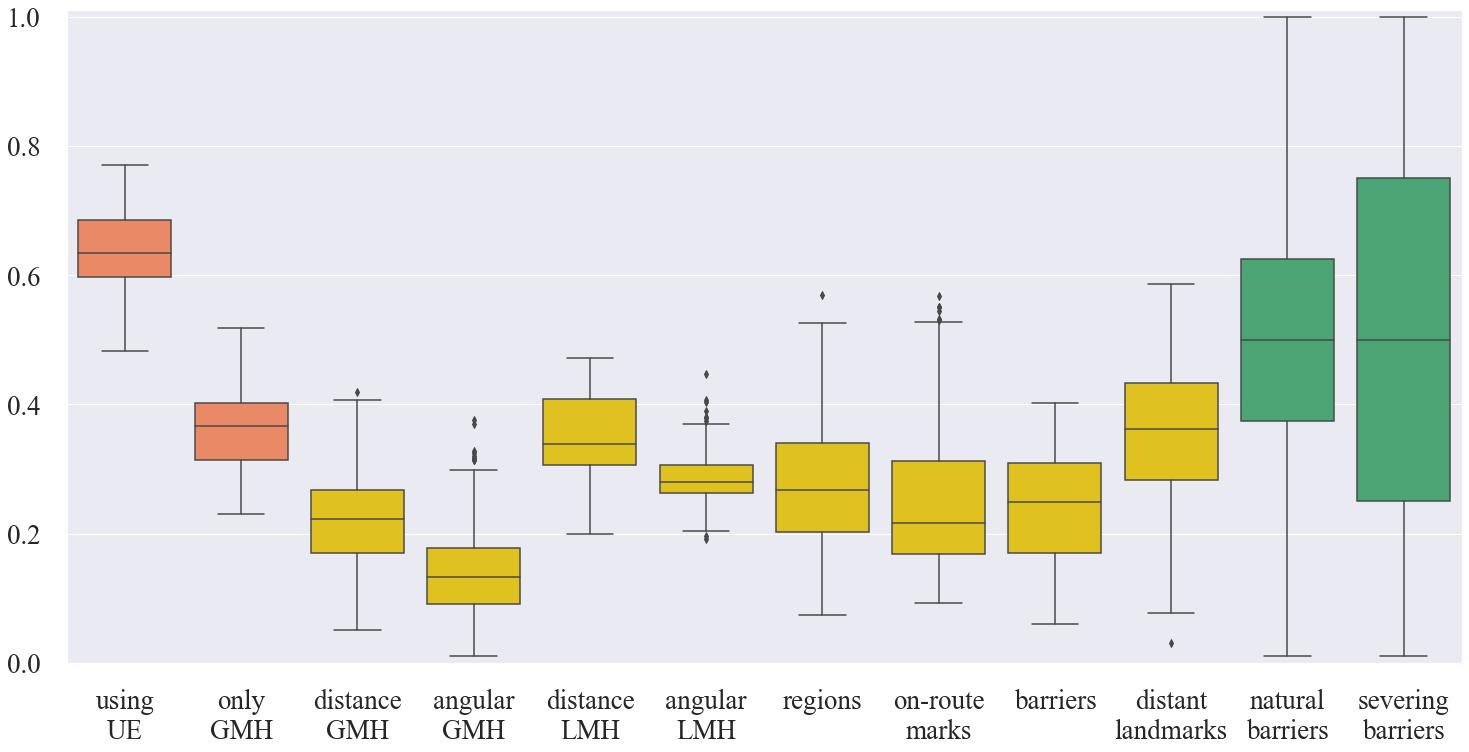

In [27]:
sns.set()
sns.set_color_codes()
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(25, 12)) 

## obtaining dataframe for boxplot visualisation
tab = pd.DataFrame(columns = {'variable', 'value'}) 
labels = ['using\nUE', 'only\nGMH', 'distance\nGMH', 'angular\nGMH', 'distance\nLMH', 'angular\nLMH', 'regions', 
          'on-route\nmarks', 'barriers', 'distant\nlandmarks', 'natural\nbarriers', 'severing\nbarriers']

tab = pd.DataFrame(columns = {'variable', 'value'}) 
index = 0
for subject in input_matrix.index:
    for n, variable in enumerate(route_variables):
        tab.at[index, 'variable'] = labels[n]
        tab.at[index, 'value'] = input_matrix.loc[subject][variable]
        index += 1

palette = ['coral']*2+['gold']*8+['mediumseagreen']*2
ax = sns.boxplot(x="variable", y="value", data=tab, palette = palette)
ax.set_ylim(0.0, 1.01)
ax.set_ylabel('', fontsize = 27, labelpad = 30, fontfamily = 'Times New Roman')
ax.set_xlabel('', labelpad = 30, fontfamily = 'Times New Roman')

for tick in ax.get_yticklabels(): 
    tick.set_fontname('Times New Roman')
for tick in ax.get_xticklabels(): 
    tick.set_fontname('Times New Roman')
    
ax.tick_params(axis='both', labelsize= 27, pad = 20)

In [28]:
fig.savefig("Outputs/Figures/empiricalABM/f4.pdf", bbox_inches='tight')

In [29]:
input_matrix[cluster_variables].mean()

onlyDistance        0.221
onlyAngular         0.141
distanceHeuristic   0.351
angularHeuristic    0.288
regions             0.271
routeMarks          0.249
barriers            0.240
distantLandmarks    0.350
dtype: float64

In [30]:
input_matrix[cluster_variables].corr(method='pearson')

,onlyDistance,onlyAngular,distanceHeuristic,angularHeuristic,regions,routeMarks,barriers,distantLandmarks
onlyDistance,1.000,-0.644,-0.281,-0.226,0.436,-0.323,-0.375,0.155
onlyAngular,-0.644,1.000,-0.394,0.033,-0.594,0.279,-0.017,-0.138
distanceHeuristic,-0.281,-0.394,1.000,-0.402,0.151,-0.136,0.616,-0.016
angularHeuristic,-0.226,0.033,-0.402,1.000,0.015,0.312,-0.279,-0.010
regions,0.436,-0.594,0.151,0.015,1.000,-0.107,-0.246,-0.295
routeMarks,-0.323,0.279,-0.136,0.312,-0.107,1.000,-0.606,-0.746
barriers,-0.375,-0.017,0.616,-0.279,-0.246,-0.606,1.000,0.523
distantLandmarks,0.155,-0.138,-0.016,-0.010,-0.295,-0.746,0.523,1.000


## 5. Cluster Analysis
### 5.1 Variables transformation

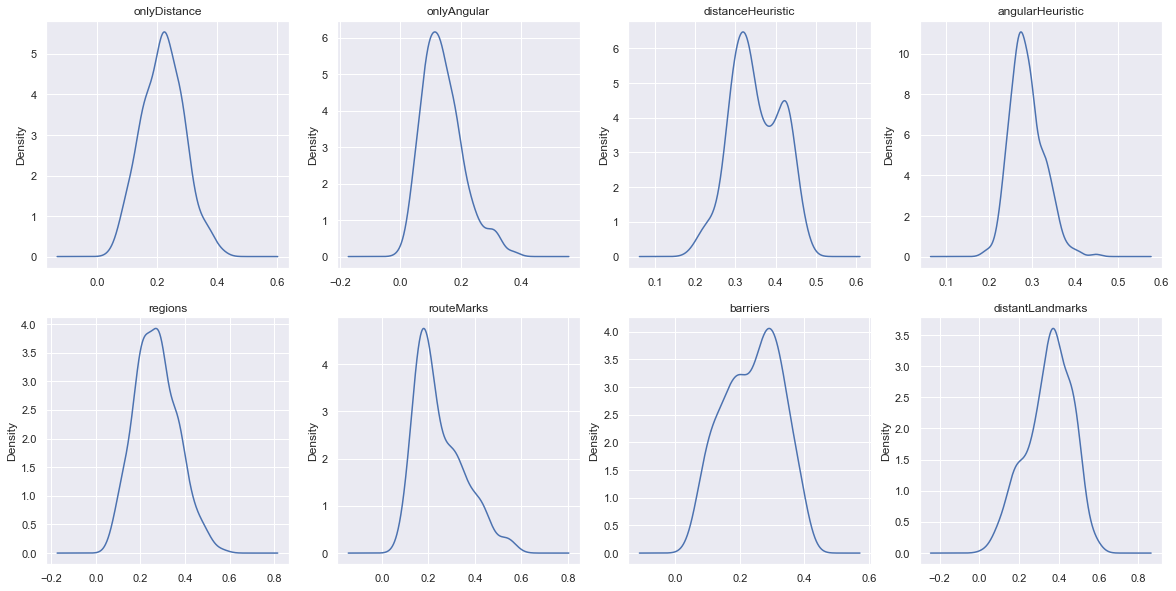

In [31]:
X = input_matrix[cluster_variables].copy()
fig = plt.figure(figsize = (20, 10))
for n, column in enumerate(list(X.columns)):
    ax = fig.add_subplot(2,4,n+1)
    ax = X[column].plot.kde()
    ax.set_title(column)

#### *Logarithmic transformation and standardisation*

In [32]:
X_log = af.log_transf(input_matrix[cluster_variables])
X_log_stand = X_log.copy()
    
for column in X_log.columns:
    X_log_stand[column] = af.standardise_column(X_log, column)

### 5.2 Obtaining and comparing different clustered structures obtained with the k-means algorithm

In [33]:
list_scores = []

def pipe_kmeans(X_toFit):

    X_tmp = X_toFit.copy()
    for n_clusters in range(2, 10):
        clusterer = KMeans(n_clusters = n_clusters, n_init = 2000).fit(X_toFit)
        labels = clusterer.labels_

        score = round(silhouette_score(X_tmp, labels, metric= 'sqeuclidean'), 3)
        param_score = {'algorithm': 'k-means', 'n_clusters' : n_clusters, 'score' : score,
                       'clusterer' : clusterer}
        list_scores.append(param_score)

pipe_kmeans(X_log_stand)
clustering = pd.DataFrame(list_scores)
clustering.sort_values(by = 'score', ascending = False)

,algorithm,n_clusters,score,clusterer
0,k-means,2,0.473,"KMeans(n_clusters=2, n_init=2000)"
4,k-means,6,0.393,"KMeans(n_clusters=6, n_init=2000)"
1,k-means,3,0.389,"KMeans(n_clusters=3, n_init=2000)"
5,k-means,7,0.389,"KMeans(n_clusters=7, n_init=2000)"
3,k-means,5,0.384,"KMeans(n_clusters=5, n_init=2000)"
6,k-means,8,0.362,KMeans(n_init=2000)
2,k-means,4,0.358,"KMeans(n_clusters=4, n_init=2000)"
7,k-means,9,0.358,"KMeans(n_clusters=9, n_init=2000)"


In [34]:
def pipe_kmeans_VCR(X):

    VRCs = []
    X_tmp = X.copy()
    X_toFit = X.copy()
    
    for n_clusters in range(2, 11):
        
        clusterer = KMeans(n_clusters = n_clusters, n_init = 2000).fit(X_toFit)
        X_tmp['cluster'] = clusterer.labels_

        f = 0.0
        for var in cluster_variables:
            arrays = []
            for cluster in list(X_tmp['cluster'].unique()):
                arrays.append(X_tmp[var+'_log'][X_tmp.cluster == cluster])
            
            if n_clusters == 2:
                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1])).statistic
            if n_clusters == 3:
                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2])).statistic
            if n_clusters == 4:
                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), 
                                     np.array(arrays[3])).statistic
            if n_clusters == 5:
                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), np.array(arrays[3]), 
                          np.array(arrays[4])).statistic
            if n_clusters == 6:
                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), np.array(arrays[3]), 
                          np.array(arrays[4]),np.array(arrays[5])).statistic
            if n_clusters == 7:
                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), np.array(arrays[3]), 
                          np.array(arrays[4]),np.array(arrays[5]),np.array(arrays[6])).statistic
            if n_clusters == 8:
                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), np.array(arrays[3]), 
                          np.array(arrays[4]), np.array(arrays[5]), np.array(arrays[6]), np.array(arrays[7])).statistic
            if n_clusters == 9:
                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), np.array(arrays[3]), 
                          np.array(arrays[4]),np.array(arrays[5]), np.array(arrays[6]), np.array(arrays[7]), np.array(arrays[8])
                                    ).statistic
            if n_clusters == 10:
                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), np.array(arrays[3]), 
                          np.array(arrays[4]), np.array(arrays[5]), np.array(arrays[6]), np.array(arrays[7]), 
                                     np.array(arrays[8]), np.array(arrays[9])).statistic
            
            f += statistic
        VRCs.append(f)   
    return VRCs

VRCs = pipe_kmeans_VCR(X_log_stand)

### 5.3 Choosing the best structure

In [35]:
for n, VRC in enumerate(VRCs):
    if (n == 0) | (n == len(VRCs)-1):
        continue
    index = (VRCs[n+1]-VRC)-(VRC-VRCs[n-1])
    print("structure with", n+2, "clusters: Omega is", round(index, 3), "VRC is", round(VRC,3))

structure with 3 clusters: Omega is -127.48 VRC is 994.793
structure with 4 clusters: Omega is 120.291 VRC is 829.467
structure with 5 clusters: Omega is 43.516 VRC is 784.431
structure with 6 clusters: Omega is -21.194 VRC is 782.912
structure with 7 clusters: Omega is -15.203 VRC is 760.2
structure with 8 clusters: Omega is -15.085 VRC is 722.284
structure with 9 clusters: Omega is 23.884 VRC is 669.284


In [84]:
chosen = clustering.loc[4]
labels_cluster = np.array(chosen.clusterer.labels_.copy())
labels_cluster += 1

In [97]:
input_with_cluster = input_matrix.copy()
input_with_cluster['cluster'] = labels_cluster

### 5.4 Examining the chosen partition

In [100]:
input_with_cluster['knowledge'] = raw['knowledge']
cluster_stats = input_with_cluster.groupby("cluster").mean()
cluster_stats

,usingElements,noElements,onlyDistance,onlyAngular,distanceHeuristic,angularHeuristic,regions,routeMarks,barriers,distantLandmarks,preferenceNatural,aversionSevering,knowledge
cluster,,,,,,,,,,,,,
1,0.682,0.318,0.143,0.175,0.415,0.268,0.286,0.352,0.260,0.196,0.460,0.517,3.581
2,0.680,0.320,0.214,0.106,0.412,0.267,0.277,0.175,0.328,0.404,0.504,0.520,3.907
3,0.590,0.410,0.240,0.170,0.303,0.287,0.209,0.172,0.258,0.446,0.504,0.460,3.775
4,0.624,0.376,0.298,0.078,0.319,0.305,0.345,0.260,0.156,0.351,0.500,0.642,3.970
5,0.616,0.384,0.206,0.178,0.313,0.303,0.316,0.436,0.095,0.160,0.435,0.500,3.405
6,0.613,0.387,0.123,0.265,0.293,0.320,0.164,0.364,0.206,0.282,0.476,0.557,3.516


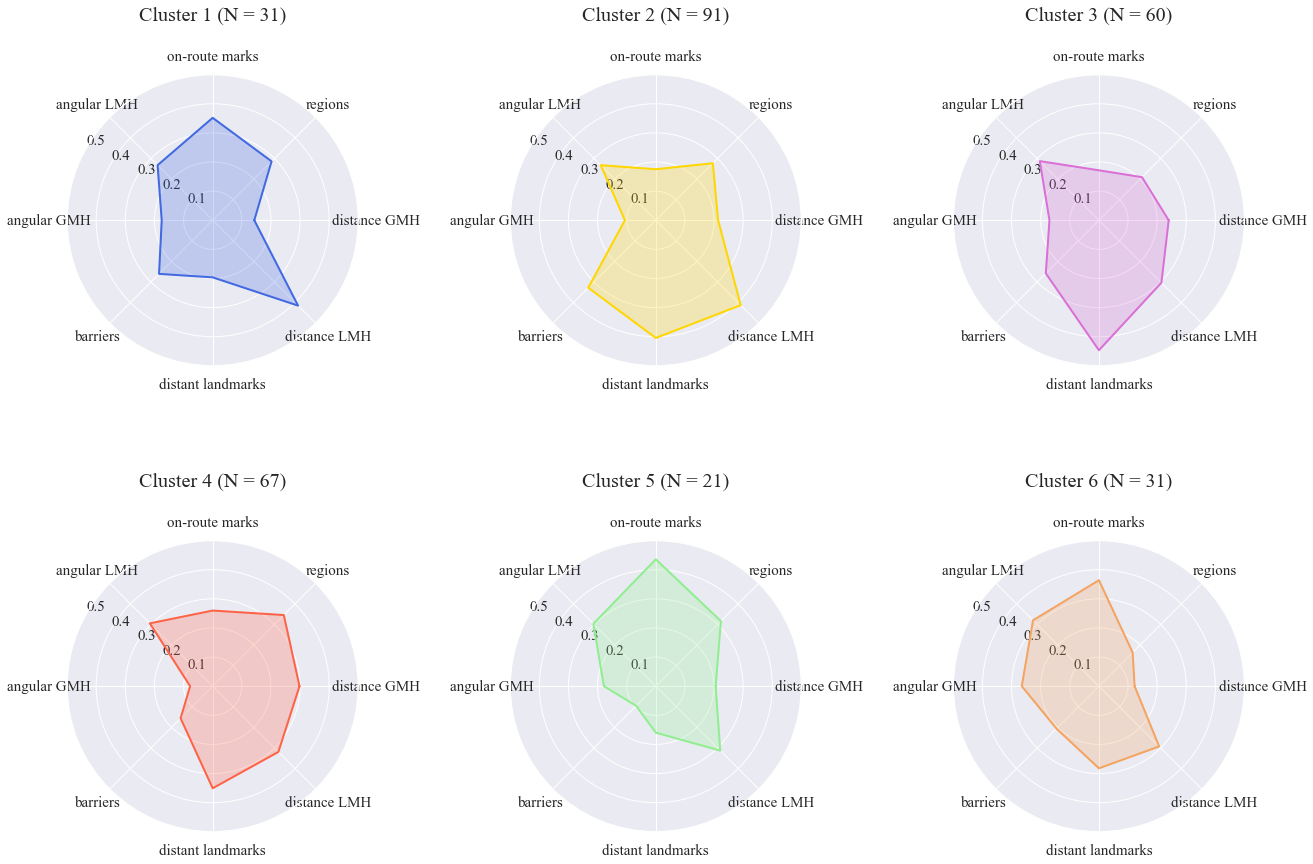

In [1369]:
sns.set()
sns.set_color_codes()

colors = ['royalblue', 'gold', 'orchid', 'tomato', 'lightgreen', 'sandybrown', 'sienna', 'darkgreen',
         'c', 'black']

clusters_stats = input_with_cluster.groupby(by = 'cluster').mean()
figsize = (22.5, (15/2*3))
fig = plt.figure(figsize = figsize)
plot_variables = ['onlyDistance',  'regions', 'routeMarks','angularHeuristic', 'onlyAngular', 'barriers', 
                  'distantLandmarks', 'distanceHeuristic']
cluster_v = np.array(plot_variables)
labels = ['distance GMH', 'regions','on-route marks','angular LMH','angular GMH','barriers','distant landmarks',
          'distance LMH'] 
plt.rcParams['font.family'] = 'Times New Roman'
to_plot = list(clusters_stats.index)

for cluster in to_plot:

    if cluster != 'population':
        tmp = clusters_stats.loc[cluster, cluster_v].values

    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    
    # close the plot
    tmp = np.concatenate((tmp,[tmp[0]]))
    angles = np.concatenate((angles,[angles[0]]))
    
    if cluster != 'population':
        ax = fig.add_subplot(3, 3, cluster, polar = True)
        color = colors[cluster-1]
    
    ax.plot(angles, tmp, '-', color = color, linewidth=2)
    ax.fill(angles, tmp, color = color, alpha=0.25)
    ax.set_thetagrids((angles * 180/np.pi)[0:len(plot_variables)], labels, fontsize = 15)
    ax.yaxis.set_ticks([0.10, 0.20, 0.30, 0.40, 0.50])
    ax.tick_params(axis='y', labelsize= 15)
    ax.tick_params(axis='x', labelsize= 15, pad = 5)
    ax.set_rlabel_position(150)
    
    if cluster != 'population':
        nr = len(input_with_cluster[input_with_cluster.cluster == cluster])
        title = "Cluster "+str(cluster) + " (N = "+str(nr)+")"      
    ax.set_title(title, va = 'bottom', fontsize = 20, pad = 50, fontfamily = 'Times New Roman')

fig.subplots_adjust(wspace=0.20, hspace = 0.60)

In [1205]:
fig.savefig("Outputs/Figures/empiricalABM/f5.pdf", bbox_inches='tight')

#### *Spatial skills - Do they explain the variation in the route choice behaviour variables?*

In [102]:
clusters = list(set(labels_cluster))
for cluster in clusters:
    knowledge = input_with_cluster[input_with_cluster.cluster == cluster]['knowledge']
    print("cluster", cluster, "spatial skills/knowledge mean:", round(knowledge.mean(), 3), "std:", round(knowledge.std(), 3))

cluster 1 spatial skills/knowledge mean: 3.581 std: 0.855
cluster 2 spatial skills/knowledge mean: 3.907 std: 0.876
cluster 3 spatial skills/knowledge mean: 3.775 std: 0.737
cluster 4 spatial skills/knowledge mean: 3.97 std: 0.738
cluster 5 spatial skills/knowledge mean: 3.405 std: 0.82
cluster 6 spatial skills/knowledge mean: 3.516 std: 0.994


In [103]:
tab = pd.DataFrame(columns = {'cluster', 'variable', 'value'}) 
labels = ['distance min.', 'angular min.', 'distance LMH', 'angular LMH', 'regions', 
          'on-route marks', 'barriers', 'distant landmarks', 'knowledge']

tab = pd.DataFrame(columns = {'cluster', 'variable', 'value'}) 
index = 0
for subject in input_with_cluster.index:
    for n, variable in enumerate(cluster_variables+['knowledge']):
        tab.at[index, 'variable'] = labels[n]
        tab.at[index, 'cluster'] = "Cluster "+str(int(input_with_cluster.loc[subject]['cluster']))
        tab.at[index, 'value'] = input_with_cluster.loc[subject][variable]
        index += 1

tab['value'] = tab.value.astype(float)
tab.sort_values('cluster', inplace = True)

In [1098]:
## using the t-test to verify whether differences in the spatial skills/knowledge are significant
pin.pairwise_ttests(data = tab[tab.variable == 'knowledge'], dv= 'value', between = 'cluster')

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,cluster,Cluster 0,Cluster 1,False,True,-1.822,53.046,two-sided,0.074,0.935,-0.372
1,cluster,Cluster 0,Cluster 2,False,True,-1.076,53.485,two-sided,0.287,0.381,-0.247
2,cluster,Cluster 0,Cluster 3,False,True,-2.188,51.472,two-sided,0.033,1.792,-0.498
3,cluster,Cluster 0,Cluster 4,False,True,0.746,44.301,two-sided,0.460,0.355,0.206
4,cluster,Cluster 0,Cluster 5,False,True,0.274,60.000,two-sided,0.785,0.267,0.069
5,cluster,Cluster 1,Cluster 2,False,True,0.995,140.269,two-sided,0.322,0.281,0.159
6,cluster,Cluster 1,Cluster 3,False,True,-0.494,153.129,two-sided,0.622,0.194,-0.077
7,cluster,Cluster 1,Cluster 4,False,True,2.496,31.452,two-sided,0.018,3.458,0.575
8,cluster,Cluster 1,Cluster 5,False,True,1.946,46.900,two-sided,0.058,1.145,0.428
9,cluster,Cluster 2,Cluster 3,False,True,-1.488,123.488,two-sided,0.139,0.516,-0.263


#### *Demographic characteristics*

In [104]:
raw['cluster'] = labels_cluster
print('Age')
cluster_deom_stats = raw.groupby("cluster")['age'].mean()
print(cluster_deom_stats)

Age
cluster
1   28.032
2   28.176
3   27.217
4   28.642
5   25.429
6   27.935
Name: age, dtype: float64


In [105]:
print('Gender')
cluster_deom_stats = raw.groupby(["cluster", 'sex'])['sex'].count()
for cluster in range(1, max(labels_cluster)+1):
    print("cluster", cluster)
    for gender in list(cluster_deom_stats.loc[cluster].index):
        print(gender, round(cluster_deom_stats.loc[cluster][gender]/cluster_deom_stats.loc[cluster].sum() *100, 1))
    print()

Gender
cluster 1
female 64.5
male 35.5

cluster 2
female 56.0
male 44.0

cluster 3
female 71.7
male 26.7
non-binary 1.7

cluster 4
female 56.7
male 41.8
non-binary 1.5

cluster 5
female 71.4
male 28.6

cluster 6
female 67.7
male 29.0
prefer not to 3.2



## 6. Final input data for building agent typologies in the ABM

In [106]:
columns = []
for column in input_with_cluster.columns:
    if column in ['knowledge', 'cluster']:
        continue
    columns.append(column+"_mean")
    columns.append(column+"_std")
    
groups = ['group'+str(cluster) for cluster in input_with_cluster['cluster'].unique()]
indexes = groups + ['population', 'nullGroup']
clusters_gdf = pd.DataFrame(index = indexes, columns = columns)
variables = route_variables


clusters = input_with_cluster['cluster'].unique()
for index in indexes:
    for variable in variables:
        if index not in ['population', 'nullGroup']:
            cluster = int(index[5:])
            clusters_gdf.at[index, variable+'_mean'] = input_with_cluster[input_with_cluster.cluster == cluster][variable].mean()
            clusters_gdf.at[index, variable+'_std'] = input_with_cluster[input_with_cluster.cluster == cluster][variable].std()
        else:
            clusters_gdf.at[index, variable+'_mean'] = input_with_cluster[variable].mean()
            clusters_gdf.at[index, variable+'_std'] = input_with_cluster[variable].std()
    
    if index not in ['population', 'nullGroup']:
        cluster = int(index[5:])
        clusters_gdf.at[index, 'portion'] = len(input_with_cluster[input_with_cluster.cluster == cluster])/len(input_with_cluster)
    else:
        clusters_gdf.at[index, 'portion'] = 1.00

In [107]:
clusters_gdf

,usingElements_mean,usingElements_std,noElements_mean,noElements_std,onlyDistance_mean,onlyDistance_std,onlyAngular_mean,onlyAngular_std,distanceHeuristic_mean,distanceHeuristic_std,...,routeMarks_std,barriers_mean,barriers_std,distantLandmarks_mean,distantLandmarks_std,preferenceNatural_mean,preferenceNatural_std,aversionSevering_mean,aversionSevering_std,portion
group2,0.680,0.042,0.320,0.042,0.214,0.045,0.106,0.031,0.412,0.031,...,0.035,0.328,0.046,0.404,0.068,0.504,0.212,0.520,0.306,0.302
group3,0.590,0.040,0.410,0.040,0.240,0.037,0.170,0.038,0.303,0.040,...,0.044,0.258,0.053,0.446,0.066,0.504,0.262,0.460,0.285,0.199
group4,0.624,0.044,0.376,0.044,0.298,0.050,0.078,0.028,0.319,0.027,...,0.061,0.156,0.040,0.351,0.066,0.500,0.219,0.642,0.279,0.223
group1,0.682,0.046,0.318,0.046,0.143,0.037,0.175,0.038,0.415,0.029,...,0.067,0.260,0.045,0.196,0.063,0.460,0.183,0.517,0.280,0.103
group5,0.616,0.046,0.384,0.046,0.206,0.044,0.178,0.037,0.313,0.021,...,0.071,0.095,0.024,0.160,0.054,0.435,0.188,0.500,0.273,0.070
group6,0.613,0.065,0.387,0.065,0.123,0.033,0.265,0.063,0.293,0.048,...,0.093,0.206,0.050,0.282,0.071,0.476,0.205,0.557,0.338,0.103
population,0.639,0.058,0.361,0.058,0.221,0.070,0.141,0.068,0.351,0.062,...,0.105,0.240,0.087,0.350,0.112,0.491,0.219,0.537,0.299,1.000
nullGroup,0.639,0.058,0.361,0.058,0.221,0.070,0.141,0.068,0.351,0.062,...,0.105,0.240,0.087,0.350,0.112,0.491,0.219,0.537,0.299,1.000


In [108]:
## exporting the files 
clusters_gdf.to_csv('Outputs/empiricalABM/'+city_name+'_clusters.csv') ## this is imported into the ABM
routes_stats.to_csv('Outputs/empiricalABM/'+city_name+'_routes_stats.csv')